In [28]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [29]:
lines = [8498.02,8542.09,8662.14]
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

vispath = path + 'VIS_notell/'
sp = glob.glob(vispath+'*TAC.csv')

In [30]:
line_list = Table.read('line_positions.ecsv')

In [31]:
all_sp = line_list

In [160]:
len(line_list[line_list['Xs'] !=  -1.0])

24

In [161]:
line_list = line_list[line_list['Xs'] !=  -1.0]

In [162]:
sp_lines, xs = line_list['FILENAME'], line_list['Xs']

In [163]:
def get_shifted_lines(x, lines):
    #calculates the approximate positions of the shifted lines
    rest_lam = lines[0]*u.AA
    obs_lam = x*u.AA
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
    #print(dv)
    l2 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[1]*u.AA))
    l3 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[2]*u.AA))
    return np.array([x, l2.value, l3.value])

def make_plot_spec(w, f, e, mask1, mask2): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1, e1 = w[mask2], f[mask2], e[mask2]
    nf = f1/n_fit(w1)
    ne = e1/n_fit(w1)
    smooth = 10
    nf = convolve(nf,Box1DKernel(smooth))
    ne = convolve(ne,Box1DKernel(smooth))/smooth**0.5
    return w1,nf, ne
    
    
def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error
#get_shifted_lines(xs[0], lines)

In [164]:
fitter = fitting.LevMarLSQFitter()
dvs = []
dves = []
dates = []
for s, x in zip(sp_lines, xs):
   # print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    dates.append(date)
    
    
  #  plt.figure() 
    for i in range(len(lines)):
        line = lines[i]
        guess = slines[i]
        if i == 0:
            gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
        else:
            gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
   #     plt.axvline(line, c='r', ls='--')
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=1000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    
  #  plt.plot(w, f)
  #  plt.plot(w, gg_fit(w))
  #  plt.show()
    obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
    obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]
    
    e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
    e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
    es = np.mean([e_up, e_down], axis=0)
    #print(len(es))
    dv, dve = dv_average(dv, es)
    dvs.append(dv)
    dves.append(dve)
    
    #dvs.append(np.mean(dv))
    #print(np.std(dv))
    
    

<ErrorbarContainer object of 3 artists>

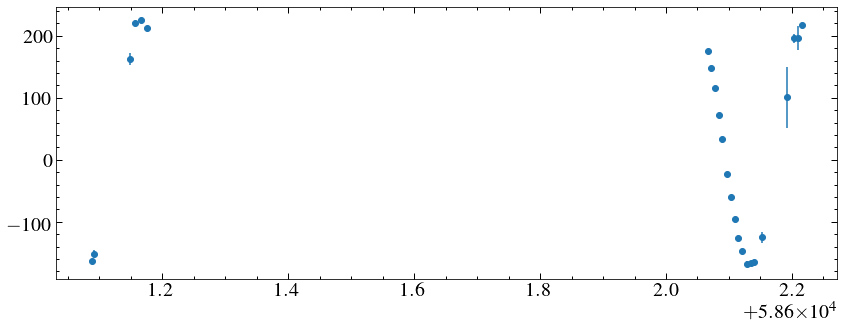

In [165]:
plt.errorbar(dates, dvs, yerr=dves, marker='o', ls='none')

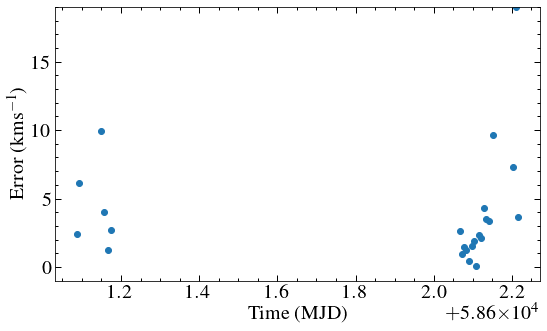

In [38]:
plt.figure(figsize=(8,5))
plt.errorbar(dates, dves, marker='o', ls='none')
plt.ylim(-1, 19)
plt.xlabel('Time (MJD)')
plt.ylabel('Error (kms$^{-1}$)')
plt.tight_layout()
plt.savefig('errortest.png')

In [39]:
from astropy.timeseries import LombScargle

In [40]:

dates = np.array(dates) + (150/86400)
args = np.argsort(dates)

In [91]:
t = dates[args]
dvs = np.array(dvs)[args]
dves= np.array(dves)[args]
t_unnorm = t*24
t = (t-t[0])*24

<ErrorbarContainer object of 3 artists>

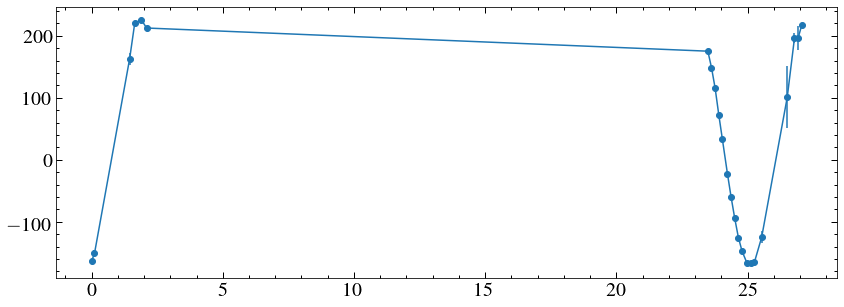

In [42]:
plt.errorbar(t, dvs, yerr=dves, marker='o')

4.217385925598945


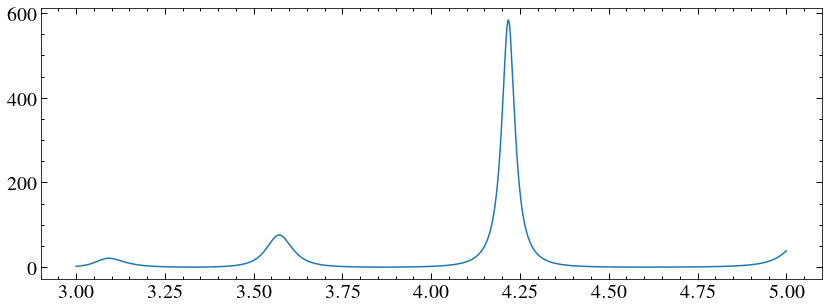

In [43]:

frequency = np.linspace(1/5, 1/3, 100000)
power = LombScargle(t, dvs, normalization='model').power(frequency)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)

<ErrorbarContainer object of 3 artists>

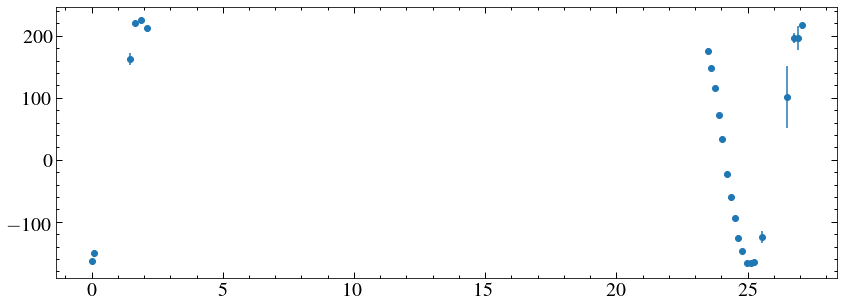

In [44]:
t_fold = (t/period) %1
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 39417.2133428176
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Model: CompoundModel279
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=27.)>

    [1]: <Sine1D(amplitude=190., frequency=0.23640662, phase=-2260.20259328)>
Parameters:
    amplitude_0 amplitude_1     frequency_1           phase_1      
    ----------- ----------- ------------------- -------------------
           27.0       190.0 0.23640661938534277 -2260.2025932837037
4.23


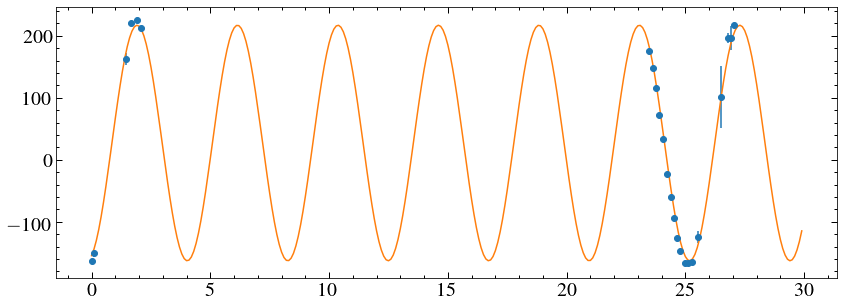

In [45]:
fitter = fitting.SLSQPLSQFitter()
sine_mod =  models.Const1D(27, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=190, frequency=1/4.23, phase = -2260.2025932837037,bounds=dict(amplitude=[170, 250], frequency=[1/4.5, 1/4.1]))
sine_fit = fitter(sine_mod, t, dvs, weights=1/dves, maxiter=100)
print(sine_fit)
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')
#phase_t = np.arange(0,1.01, 0.01 )
#plt.plot(phase_t, sine_fit(phase_t))
t_plot = np.arange(0, 30, 0.1)
plt.plot(t_plot, sine_fit(t_plot))
print(1/sine_fit[1].frequency)

In [46]:
#print (max(dvs) - abs(min(dvs)))
#print(max(dvs - ))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1157.6216207269667
            Iterations: 11
            Function evaluations: 75
            Gradient evaluations: 11
Model: CompoundModel280
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0       amplitude_1    frequency_1      phase_1      
    ------------------ ---------------- ----------- ------------------
    26.182914824978486 196.152722416969         1.0 -4122.207450606172


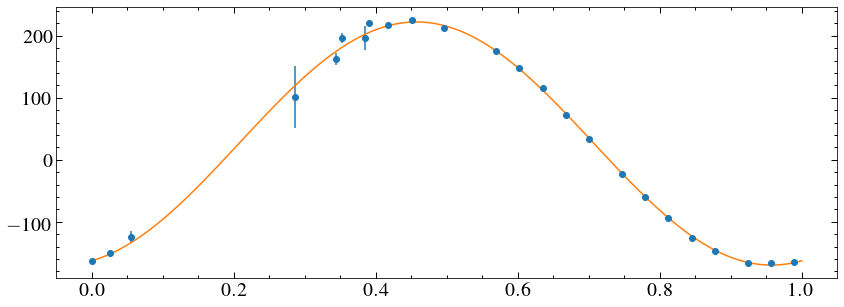

In [47]:
fitter = fitting.SLSQPLSQFitter()
#fitter = fitting.LevMarLSQFitter()

sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[100, 200]), fixed=dict(frequency=1))
sine_fit = fitter(sine_mod, t_fold, dvs, maxiter=100000)
print(sine_fit)
plt.errorbar(t_fold, dvs, yerr=dves, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
#t_plot = np.arange(0, 30, 0.1)
#plt.plot(t_plot, sine_fit(t_plot))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 246587.56617620453
            Iterations: 13
            Function evaluations: 118
            Gradient evaluations: 11
Model: CompoundModel281
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0        amplitude_1     frequency_1      phase_1      
    ------------------ ------------------ ----------- ------------------
    36.567591566940564 170.00000000000009         1.0 1074.0828715217956


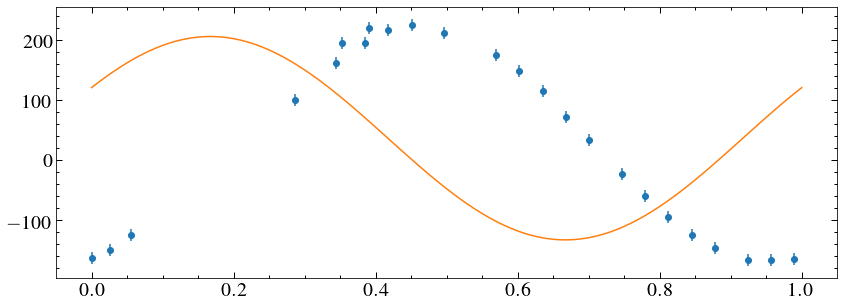

In [48]:
fitter = fitting.SLSQPLSQFitter()
#fitter = fitting.LevMarLSQFitter()
errs = np.full(len(t_fold), 10)
sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[170, 250]), fixed=dict(frequency=1))
sine_fit = fitter(sine_mod, t_fold, dvs, errs, maxiter=10000)
print(sine_fit)
plt.errorbar(t_fold, dvs, yerr=errs, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
#t_plot = np.arange(0, 30, 0.1)
#plt.plot(t_plot, sine_fit(t_plot))

Can't deal with errors for some reason -fixed- weights = 1/e

Try the absorption lines?

In [49]:
abs_dates = []
for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    abs_dates.append(date)
abs_args = np.argsort(abs_dates)

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_0_TAC.csv


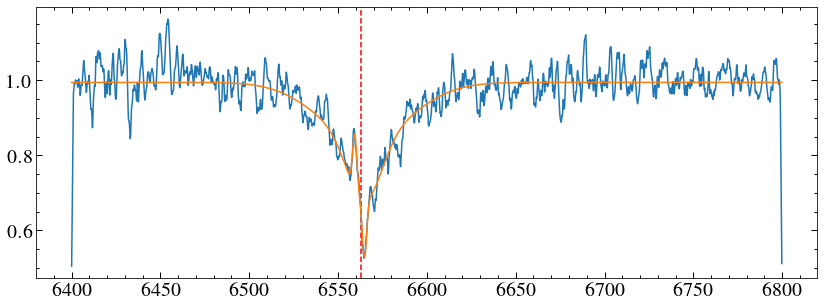

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_1_TAC.csv


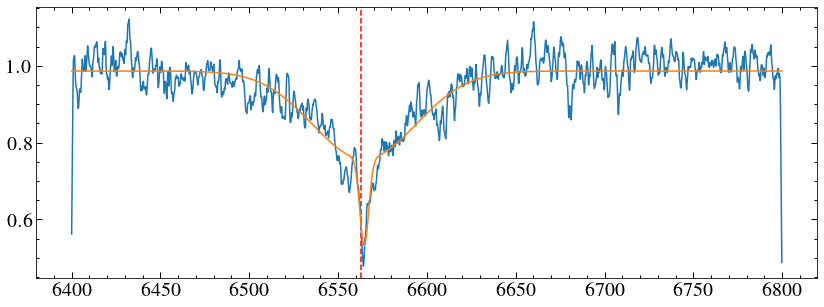

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_2_TAC.csv


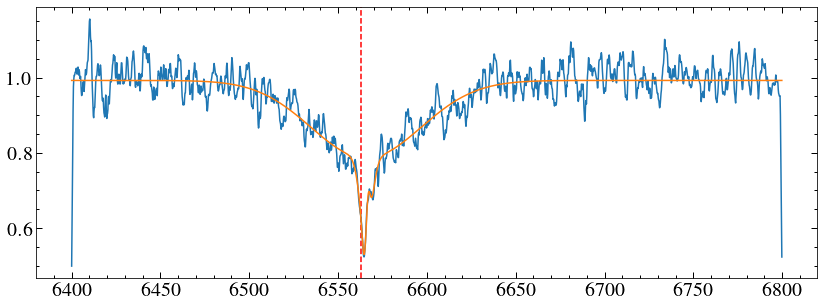

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_3_TAC.csv


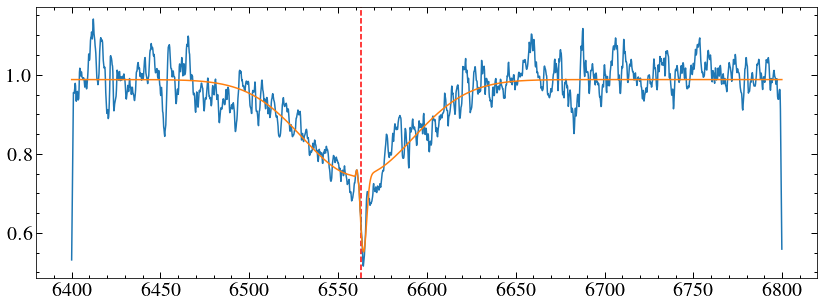

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_4_TAC.csv


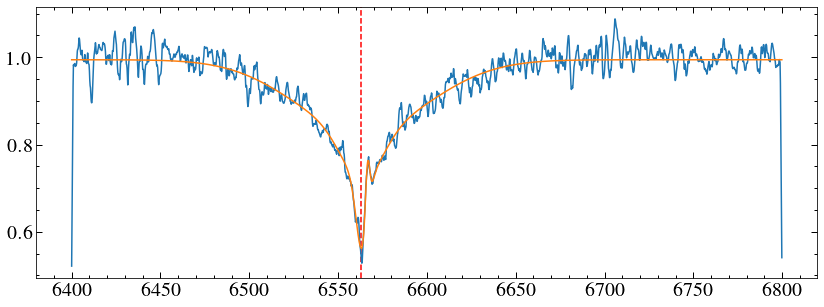

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_5_TAC.csv


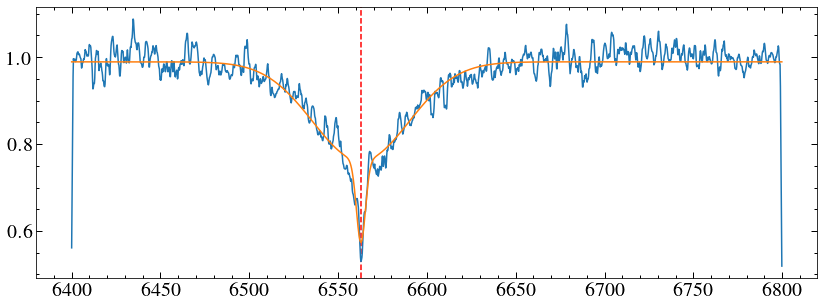

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_6_TAC.csv


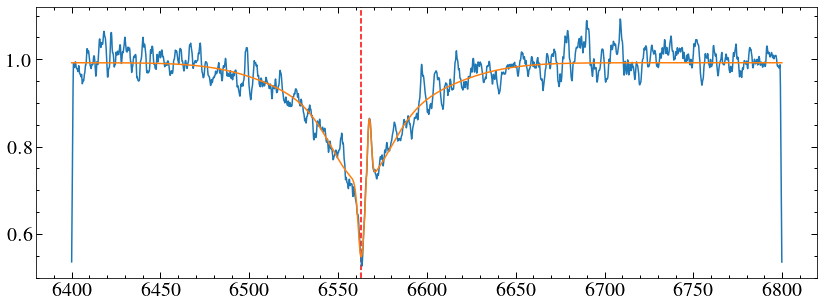

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_7_TAC.csv


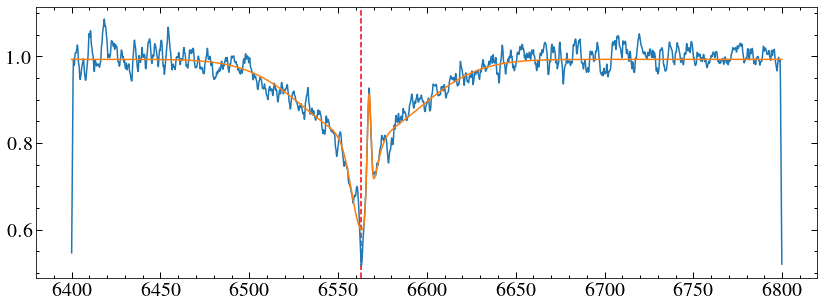

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_8_TAC.csv


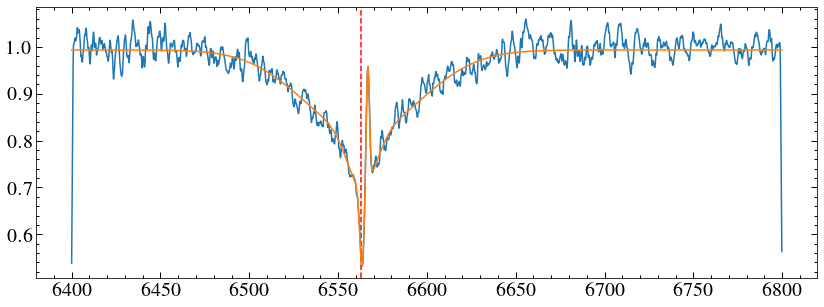

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_9_TAC.csv


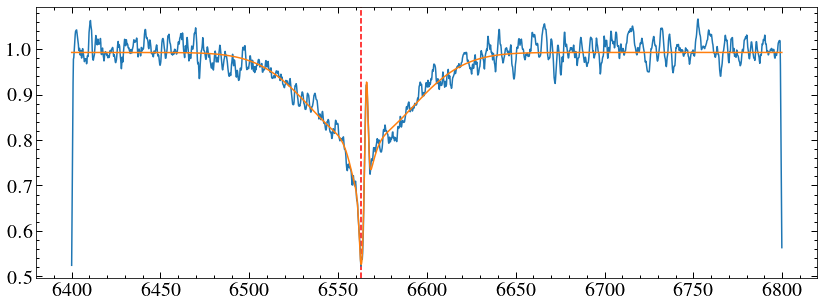

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_10_TAC.csv


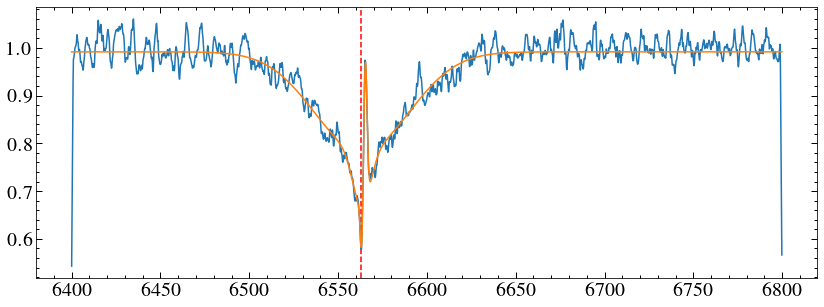

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_11_TAC.csv


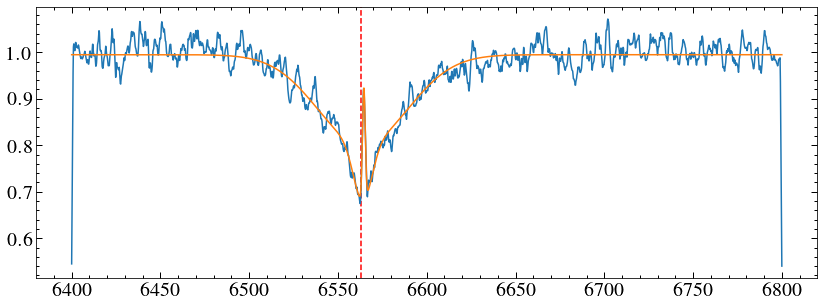

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_12_TAC.csv


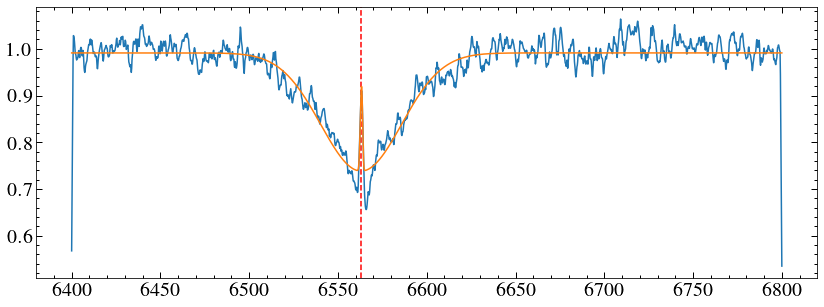

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_13_TAC.csv


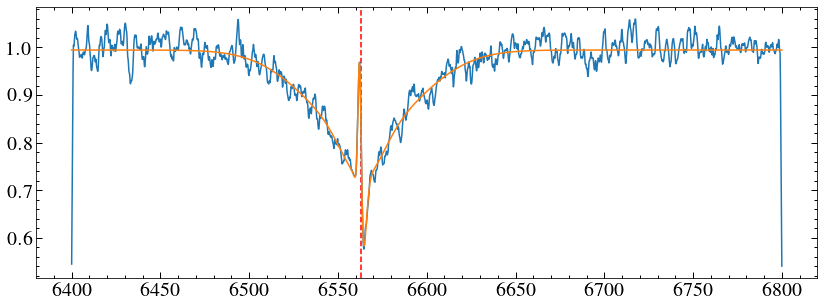

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_14_TAC.csv


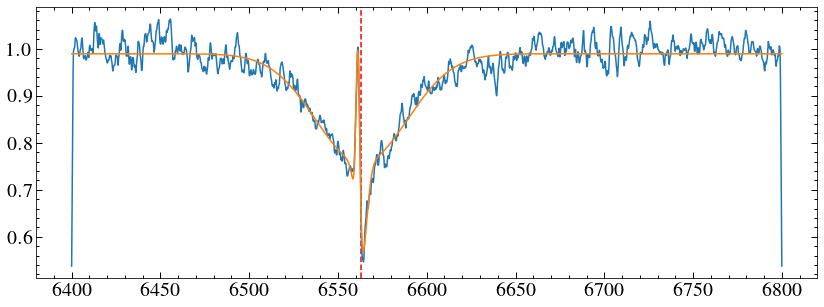

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_15_TAC.csv


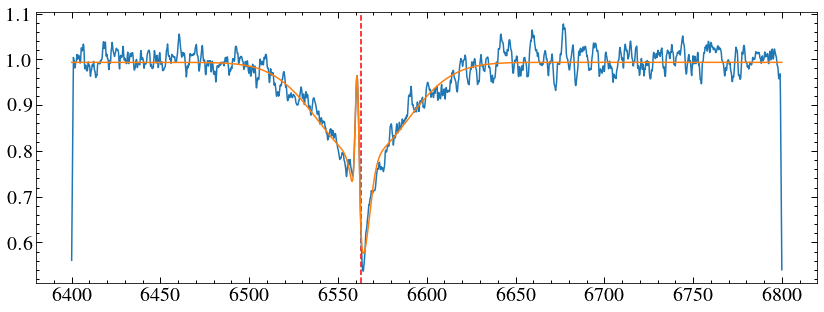

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_16_TAC.csv


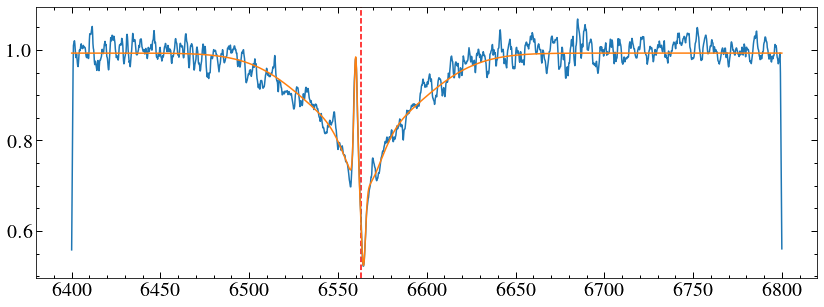

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_17_TAC.csv


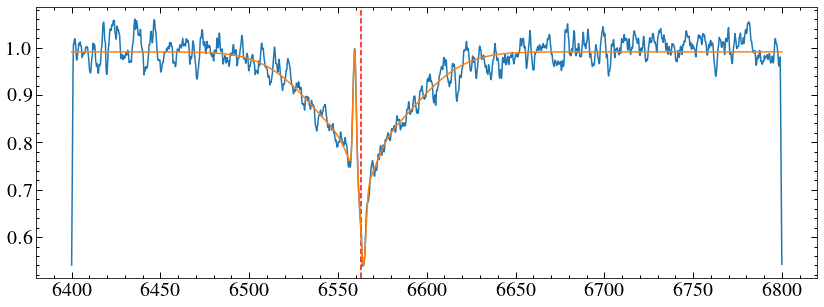

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_18_TAC.csv


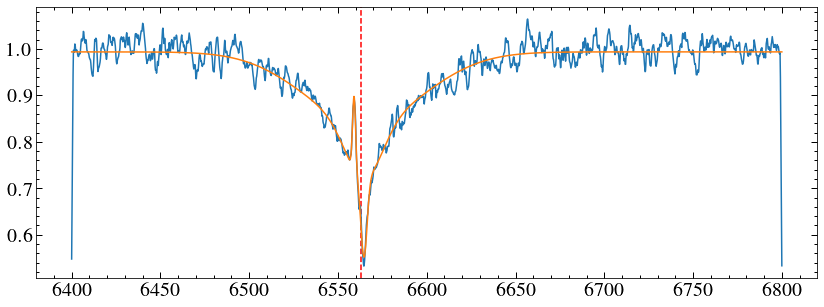

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_19_TAC.csv


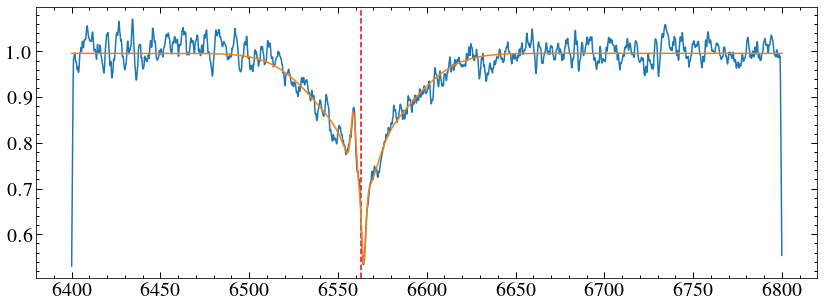

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_20_TAC.csv


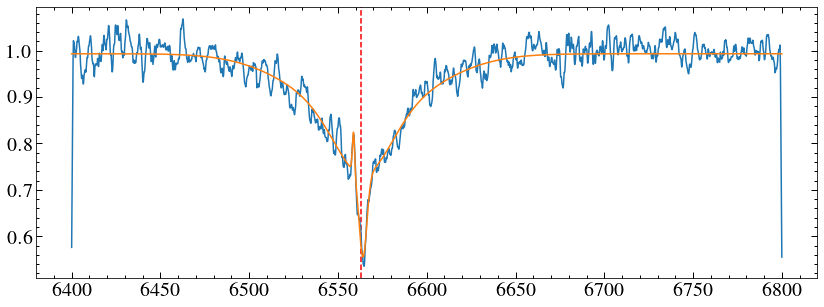

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_21_TAC.csv


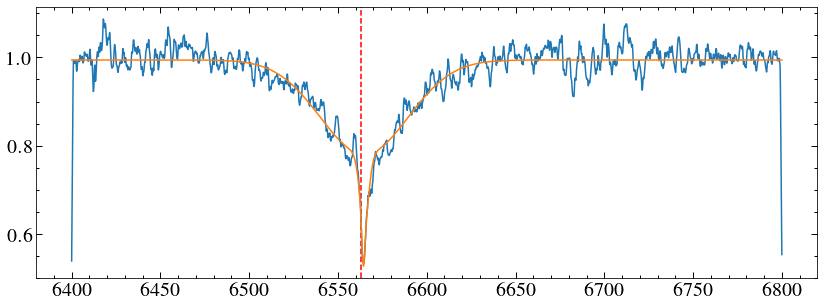

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_22_TAC.csv


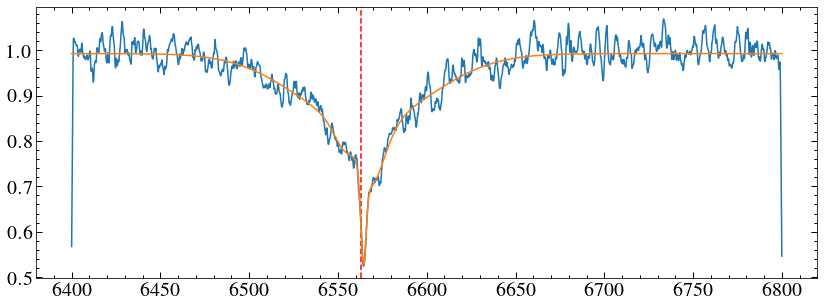

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_23_TAC.csv


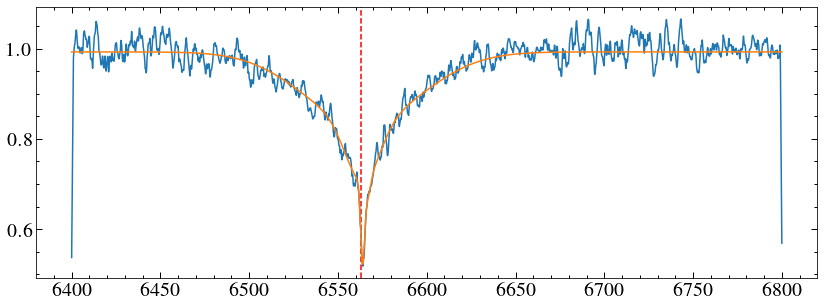

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_24_TAC.csv


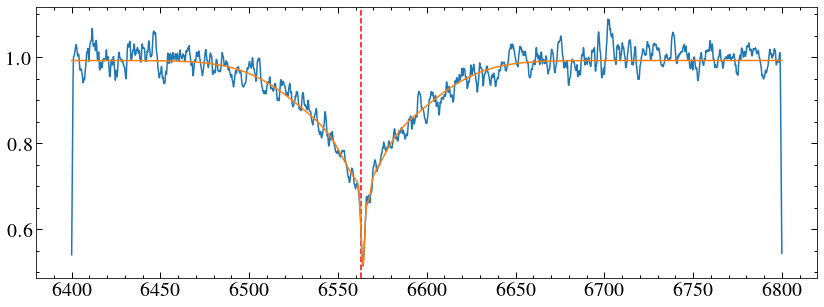

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_25_TAC.csv


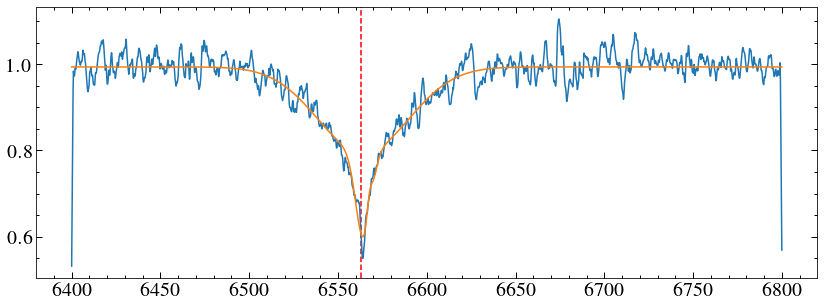

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_26_TAC.csv


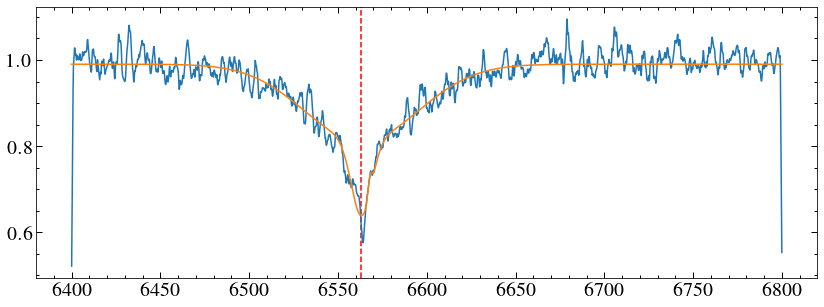

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_27_TAC.csv


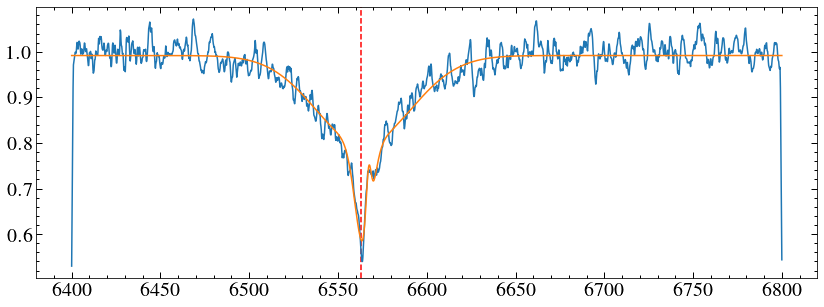

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_28_TAC.csv


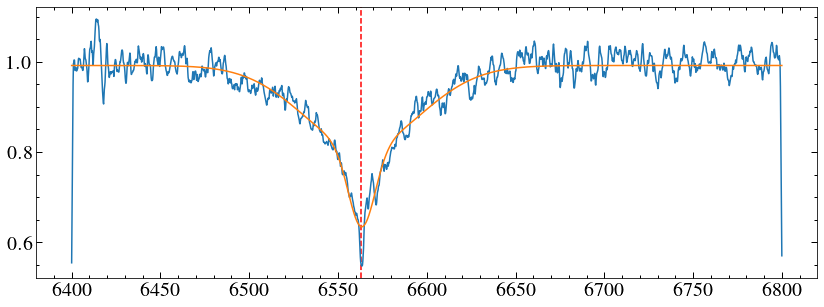

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_29_TAC.csv


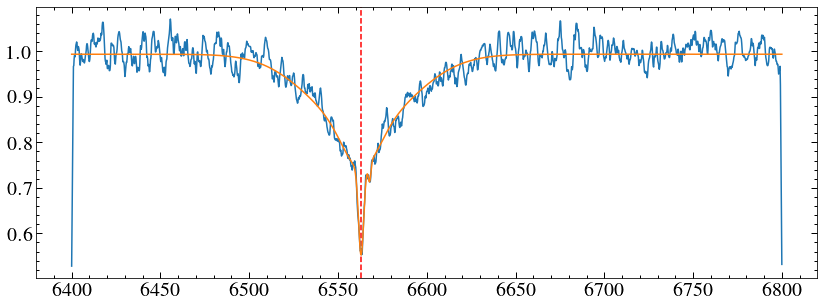

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_30_TAC.csv


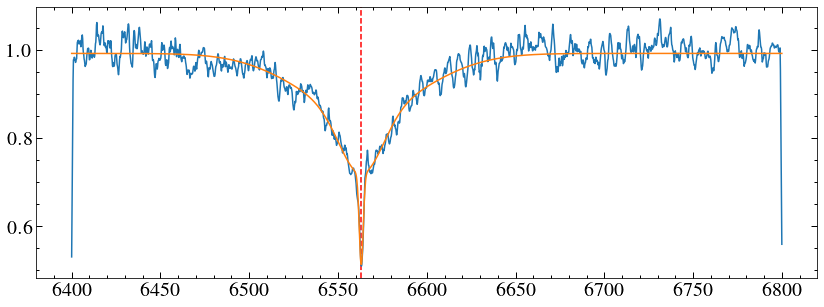

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_31_TAC.csv


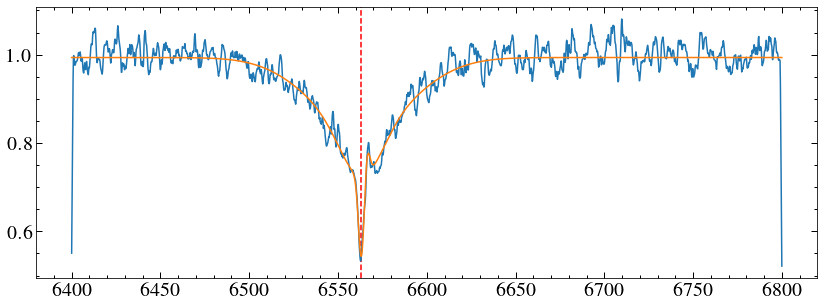

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_32_TAC.csv


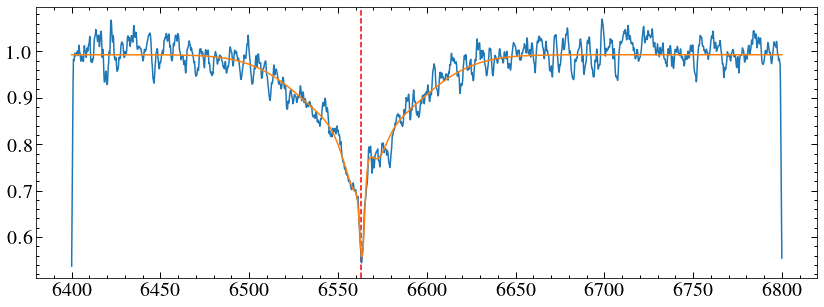

In [50]:
#def mean_and_error:
    

fitter = fitting.LevMarLSQFitter()
abs_dvs = []
abs_dves = []
abs_dates = []
halpha = 6562.77
h_em = []
dvs_1 = []
dvs_2 = []
dvs_3 = []

def tiedfunc(gg_init):
    mean = gg_init.mean_1.value
    return mean


sp_lines, xs = all_sp['FILENAME'][abs_args], all_sp['Xs'][abs_args]

#for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
for s, x in zip(sp_lines, xs):
    print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
    mask2 = (w> 6400) & (w < 6800) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    abs_dates.append(date)
    
    
    plt.figure() 
  #, bounds={'amplitude':[-0.1, -0.3]}
    plt.axvline(halpha, c='r', ls='--')
    gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.4, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0) 

    gg_init.stddev_1.bounds = [0.1, 1.2]
    gg_init.stddev_0.bounds = [1.5,6]
    
    if x != -1:
        rest_lam = lines[0]*u.AA
        obs_lam = x*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        h_guess = dv.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    else:
    #    h_guess = halpha-5
        dt_fold = (date*24)/period %1
        h_guess = sine_fit(dt_fold)*u.km/u.s
        h_guess = h_guess.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    gg_init += models.Gaussian1D(1.0, h_guess,0.5, bounds={'mean':[h_guess-1, h_guess+1], 'stdev':[0.1, 3]})
    gg_init.mean_0.tied=tiedfunc
    gg_init.mean_2.tied=tiedfunc


    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=100000)
   # fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    
    plt.plot(w, f)
    plt.plot(w, gg_fit(w))
    plt.show()
    
    obs_line = gg_fit[1].mean*u.AA
    #obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    em_line = gg_fit[4].mean*u.AA
    dv_em = em_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    h_em.append(dv_em)
    abs_dvs.append(dv)
    
    dvs_1.append((gg_fit[0].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value)
    dvs_2.append((gg_fit[1].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value)
    dvs_3.append((gg_fit[2].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value)
    
    if s == '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_12_TAC.csv':
        test= gg_fit
    
    #abs_dves.append(dve)
    
    

<ErrorbarContainer object of 3 artists>

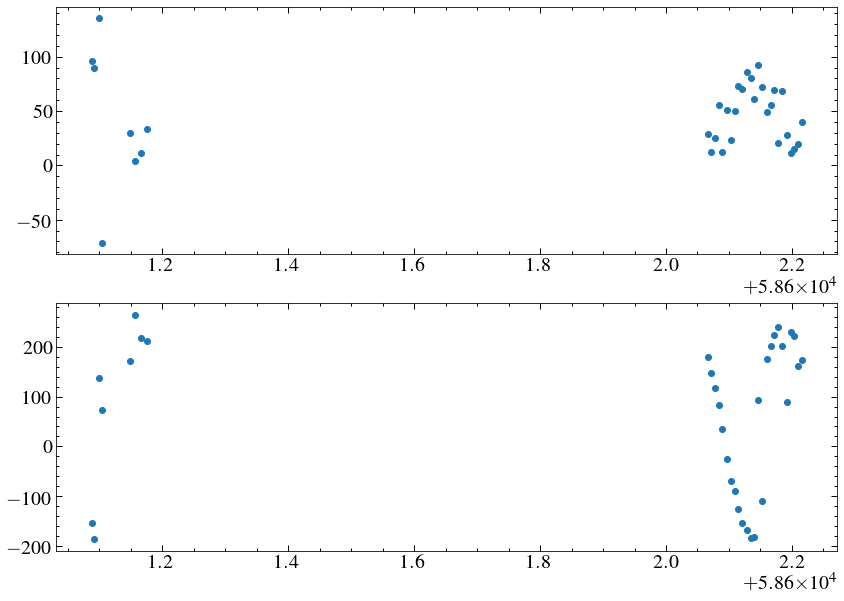

In [51]:
plt.figure(figsize=(14, 10))
plt.subplot(211)
plt.errorbar(abs_dates, abs_dvs, ls='none', marker='o')
#plt.ylim(-100, 200)
plt.subplot(212)
plt.errorbar(abs_dates, h_em, ls='none', marker='o')


<ErrorbarContainer object of 3 artists>

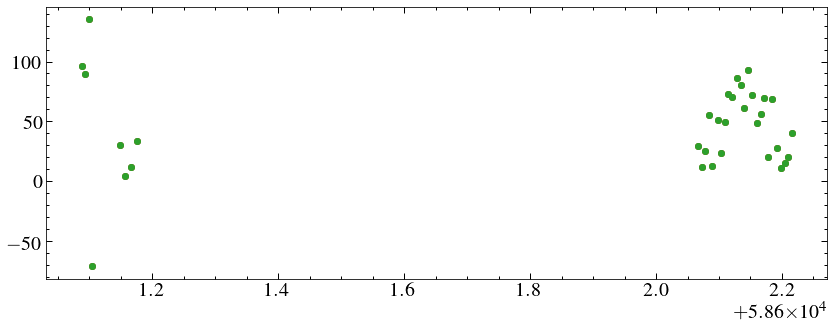

In [52]:
plt.errorbar(abs_dates, dvs_1, ls='none', marker='o')
plt.errorbar(abs_dates, dvs_2, ls='none', marker='o')
plt.errorbar(abs_dates, dvs_3, ls='none', marker='o')

#dvs_avs = np.mean([dvs_1, dvs_2, dvs_3], axis=0)
#dvs_std = np.std([dvs_1, dvs_2, dvs_3], axis=0)
#plt.errorbar(abs_dates, dvs_avs, yerr=dvs_std, ls='none', marker='o')

<ErrorbarContainer object of 3 artists>

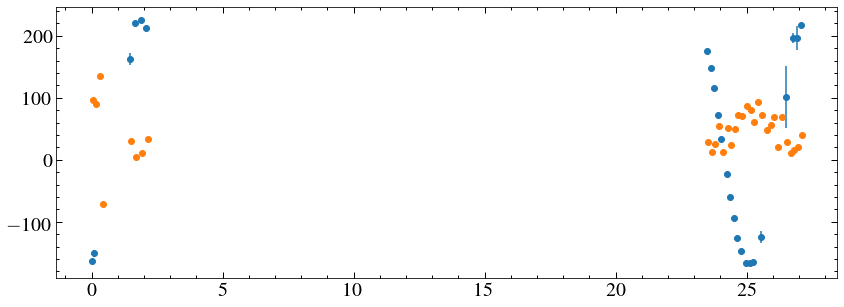

In [53]:
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')
t_abs = (abs_dates - min(np.array(abs_dates))+(150/86400))*24
plt.errorbar(t_abs, abs_dvs, ls='none', marker='o')

(-50, 150)

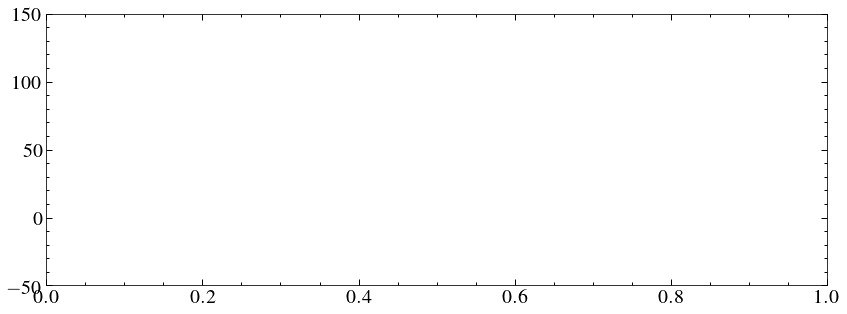

In [55]:
abs_fold = (t_abs/period) %1
#plt.errorbar(abs_fold, dvs_avs, ls='none', marker='o')
plt.ylim(-50, 150)

In [56]:
fake_dv = np.random.normal(dvs, dves)

<ErrorbarContainer object of 3 artists>

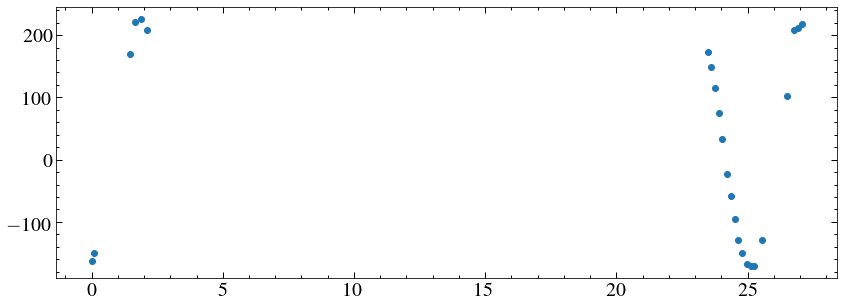

In [57]:
plt.errorbar(t, fake_dv, ls='none', marker='o')

4.217385925598945
4.21935521981654


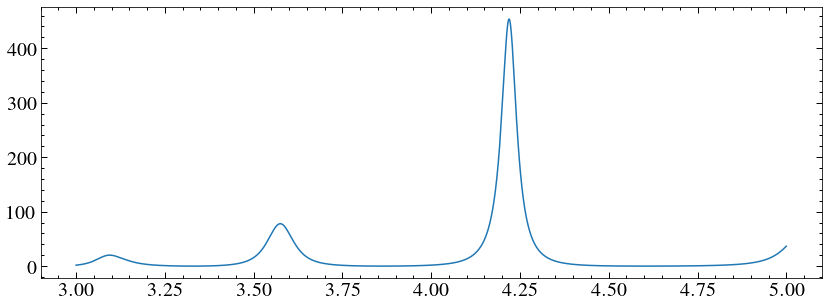

In [58]:
frequency = np.linspace(1/5, 1/3, 100000)
power = LombScargle(t, fake_dv, normalization='model').power(frequency)
fake_period = 1/frequency[np.argmax(power)]
print(period)
print(fake_period)
plt.plot(1/frequency, power)

In [59]:
fake_periods = []
i = 0
while i < 1000:
    fake_dv = np.random.normal(dvs, dves)
    power = LombScargle(t, fake_dv, normalization='model').power(frequency)
    fake_period = 1/frequency[np.argmax(power)]
    fake_periods.append(fake_period)
    i +=1
    

(array([  2.,  97.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   9., 230., 468., 182.,   9.]),
 array([3.53877713, 3.55312716, 3.56747719, 3.58182723, 3.59617726,
        3.61052729, 3.62487733, 3.63922736, 3.65357739, 3.66792743,
        3.68227746, 3.69662749, 3.71097753, 3.72532756, 3.73967759,
        3.75402762, 3.76837766, 3.78272769, 3.79707772, 3.81142776,
        3.82577779, 3.84012782, 3.85447786, 3.86882789, 3.88317792,
        3.89752796, 3.91187799, 3.92622802, 3.94057805, 3.95492809,
        3.96927812, 3.98362815, 3.99797819, 4.01232822, 4.02667825,
        4.04102829, 4.05537832, 4.06972835, 4.08407839, 4.09842842,
        4.11277845, 4.12712849, 4.14147852, 4.15582855, 4.17017858,
        4.18452862, 4.19887865, 4.21322868, 4.

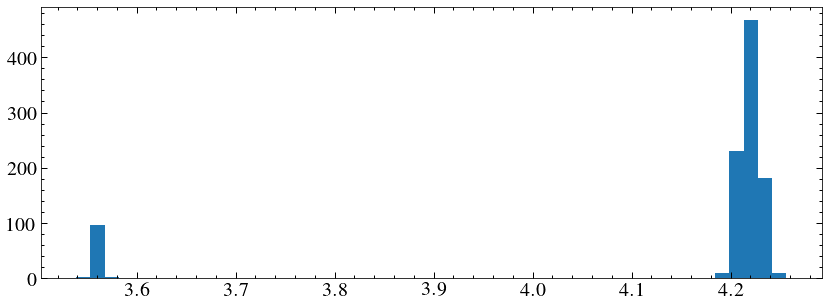

In [60]:
plt.hist(fake_periods, bins=50)

In [61]:
fake_periods = np.array(fake_periods)
print(np.median(fake_periods[fake_periods > 4]))
print (np.std(fake_periods[fake_periods > 4]))

4.21935521981654
0.00966462248753557


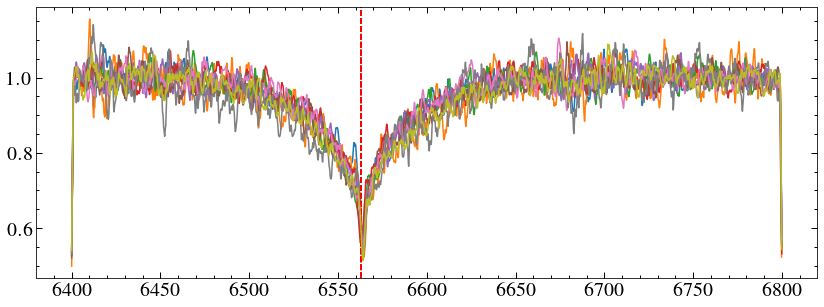

In [62]:

halpha = 6562.77


for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
    if x == -1:
   # print(s)
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        slines = get_shifted_lines(x, lines)
        mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
        mask2 = (w> 6400) & (w < 6800) 
        w, f, e =  make_plot_spec(w, f,e , mask1, mask2)


       # plt.figure() 

        plt.axvline(halpha, c='r', ls='--')

        plt.plot(w, f)

        #plt.show()


    
    

In [63]:
"""
fitter = fitting.LevMarLSQFitter()
norms = []
means = []
amplitudes = []
stds = []
clean_dates = []

halpha = 6562.77

def tiedfunc(gg_init):
    mean = gg_init.mean_0.value
    return mean

#sp_lines, xs = , line_list
for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
    if x == -1:
        
   # print(s)
        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
        slines = get_shifted_lines(x, lines)
        mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
        mask2 = (w> 6400) & (w < 6800) 
        w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
        #plt.plot(w, f)
        date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
        clean_dates.append(date)


        plt.figure() 

        plt.axvline(halpha, c='r', ls='--')
        gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.5, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0)
        gg_init.mean_1.tied=tiedfunc
        gg_init.mean_2.tied=tiedfunc
      


        gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=1000)
        #fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

       # print(gg_fit)
        #print(fit_e)

        plt.plot(w, f)
        plt.plot(w, gg_fit(w))
        plt.show()
        
        norms.append(gg_fit[3].amplitude.value)
        means.append([gg_fit[0].mean.value, gg_fit[1].mean.value, gg_fit[2].mean.value])
        amplitudes.append([gg_fit[0].amplitude.value, gg_fit[1].amplitude.value, gg_fit[2].amplitude.value])
        stds.append([gg_fit[0].stddev.value, gg_fit[1].stddev.value, gg_fit[2].stddev.value])

  
""" 
    

"\nfitter = fitting.LevMarLSQFitter()\nnorms = []\nmeans = []\namplitudes = []\nstds = []\nclean_dates = []\n\nhalpha = 6562.77\n\ndef tiedfunc(gg_init):\n    mean = gg_init.mean_0.value\n    return mean\n\n#sp_lines, xs = , line_list\nfor s, x in zip(all_sp['FILENAME'], all_sp['Xs']):\n    if x == -1:\n        \n   # print(s)\n        w, f, e = np.loadtxt(s, unpack=True, delimiter=',')\n        slines = get_shifted_lines(x, lines)\n        mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)\n        mask2 = (w> 6400) & (w < 6800) \n        w, f, e =  make_plot_spec(w, f,e , mask1, mask2)\n        #plt.plot(w, f)\n        date = fits.getheader(s[:-3]+'fits')['MJD-OBS']\n        clean_dates.append(date)\n\n\n        plt.figure() \n\n        plt.axvline(halpha, c='r', ls='--')\n        gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.5, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0)\n        gg_init.mean_1.tied=tiedfunc\n        gg_init.mean_

In [64]:
#means_av = np.mean(means, axis=1)
#means_av
#plt.errorbar(clean_dates, means_av, ls='none', marker='o')

In [65]:
#plt.errorbar(clean_dates, , ls='none', marker='o')
#amplitudes, stds = np.array(amplitudes), np.array(stds)
#plt.errorbar(clean_dates, amplitudes[:,0], ls='none', marker='o')
#plt.errorbar(clean_dates, amplitudes[:,1], ls='none', marker='o')
#plt.errorbar(clean_dates, amplitudes[:,2], ls='none', marker='o')


In [66]:
#plt.errorbar(clean_dates, stds[:,0], ls='none', marker='o')
#plt.errorbar(clean_dates, stds[:,1], ls='none', marker='o')
#plt.errorbar(clean_dates, stds[:,2], ls='none', marker='o')


In [67]:
period

4.217385925598945

In [68]:
gg_fit

<CompoundModel413(amplitude_0=-0.17372401, mean_0=6563.6471773, stddev_0=1.37645226, amplitude_1=-0.1574607, mean_1=6563.6471773, stddev_1=8.03581085, amplitude_2=-0.17192334, mean_2=6563.6471773, stddev_2=30.89250859, amplitude_3=0.99281169, amplitude_4=0.09177171, mean_4=6566.56258675, stddev_4=3.8292262)>

In [69]:
test

<CompoundModel333(amplitude_0=0.09948054, mean_0=6563.04273609, stddev_0=0., amplitude_1=0.13114981, mean_1=6563.04273609, stddev_1=0.61706881, amplitude_2=-0.25300793, mean_2=6563.04273609, stddev_2=22.6983355, amplitude_3=0.99119477, amplitude_4=0.07376763, mean_4=6563.54587505, stddev_4=0.43690844)>

In [70]:
#np.sort(all_sp['FILENAME'])

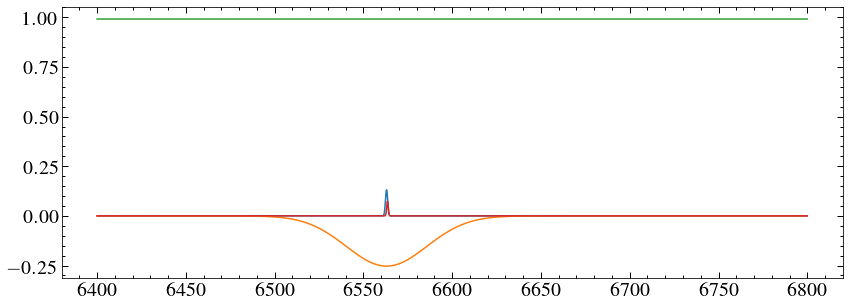

In [71]:
#plt.plot(w, test[0](w))
plt.plot(w, test[1](w))
plt.plot(w, test[2](w))
plt.plot(w, test[3](w))
plt.plot(w, test[4](w))

20190901 Looks like we can kind of fit the abs lines. Fix to each of the centers, see the difference and use that as the error?

In [72]:
fitter = fitting.LevMarLSQFitter()
abs_dvs = []
abs_dves = []
abs_dates = []
halpha = 6562.77
h_em = []
dvs_1 = []
dvs_2 = []
dvs_3 = []

def tiedfunc0(gg_init):
    mean = gg_init.mean_0.value
    return mean


def tiedfunc1(gg_init):
    mean = gg_init.mean_1.value
    return mean

def tiedfunc2(gg_init):
    mean = gg_init.mean_2.value
    return mean

sp_lines, xs = all_sp['FILENAME'][abs_args], all_sp['Xs'][abs_args]

#for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
for s, x in zip(sp_lines, xs):
    print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
    mask2 = (w> 6400) & (w < 6800) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    abs_dates.append(date)
    
    
  #  plt.figure() 
  #, bounds={'amplitude':[-0.1, -0.3]}
   # plt.axvline(halpha, c='r', ls='--')
    gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.4, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0) 

    gg_init.stddev_1.bounds = [0.1, 1.2]
    gg_init.stddev_0.bounds = [1.5,6]
    
    if x != -1:
        rest_lam = lines[0]*u.AA
        obs_lam = x*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        h_guess = dv.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    else:
    #    h_guess = halpha-5
        dt_fold = (date*24)/period %1
        h_guess = sine_fit(dt_fold)*u.km/u.s
        h_guess = h_guess.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    gg_init += models.Gaussian1D(1.0, h_guess,0.5, bounds={'mean':[h_guess-1, h_guess+1], 'stdev':[0.1, 3]})
    gg_init.mean_1.tied=tiedfunc0
    gg_init.mean_2.tied=tiedfunc0
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=100000)
    dvs_1.append((gg_fit[1].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value)
    
    
    gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.4, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0) 

    gg_init.stddev_1.bounds = [0.1, 1.2]
    gg_init.stddev_0.bounds = [1.5,6]
    
    if x != -1:
        rest_lam = lines[0]*u.AA
        obs_lam = x*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        h_guess = dv.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    else:
    #    h_guess = halpha-5
        dt_fold = (date*24)/period %1
        h_guess = sine_fit(dt_fold)*u.km/u.s
        h_guess = h_guess.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    gg_init += models.Gaussian1D(1.0, h_guess,0.5, bounds={'mean':[h_guess-1, h_guess+1], 'stdev':[0.1, 3]})
    gg_init.mean_0.tied=tiedfunc1
    gg_init.mean_2.tied=tiedfunc1
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=100000)
    dvs_2.append((gg_fit[1].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value)
    
    
    gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.4, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0) 

    gg_init.stddev_1.bounds = [0.1, 1.2]
    gg_init.stddev_0.bounds = [1.5,6]
    
    if x != -1:
        rest_lam = lines[0]*u.AA
        obs_lam = x*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        h_guess = dv.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    else:
    #    h_guess = halpha-5
        dt_fold = (date*24)/period %1
        h_guess = sine_fit(dt_fold)*u.km/u.s
        h_guess = h_guess.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    gg_init += models.Gaussian1D(1.0, h_guess,0.5, bounds={'mean':[h_guess-1, h_guess+1], 'stdev':[0.1, 3]})
    
    gg_init.mean_0.tied=tiedfunc2
    gg_init.mean_1.tied=tiedfunc2
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=100000)
    dvs_3.append((gg_fit[2].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value)
    
    
   # fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    
    #plt.plot(w, f)
    #plt.plot(w, gg_fit(w))
    #plt.show()
    
   # obs_line = gg_fit[1].mean*u.AA
    #obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    #dv = obs_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    em_line = gg_fit[4].mean*u.AA
    dv_em = em_line.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    h_em.append(dv_em)
    #abs_dvs.append(dv)
    
    #dvs_1.append((gg_fit[0].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value)
    #dvs_2.append((gg_fit[1].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value)
    #dvs_3.append((gg_fit[2].mean*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value)
    
    if s == '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_12_TAC.csv':
        test= gg_fit
    
    #abs_dves.append(dve)
    
    

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_0_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_1_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_2_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_3_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_4_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_5_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_6_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+

<ErrorbarContainer object of 3 artists>

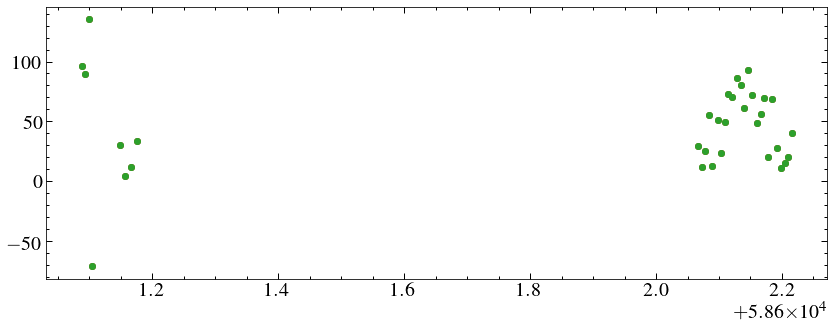

In [73]:
plt.errorbar(abs_dates, dvs_1, ls='none', marker='o')
plt.errorbar(abs_dates, dvs_2, ls='none', marker='o')
plt.errorbar(abs_dates, dvs_3, ls='none', marker='o')

Great, it doesn't depend on which gaussian is used. Try doing it once and bruteforce it to get the errors

In [74]:
fitter = fitting.LevMarLSQFitter()
abs_dvs = []
abs_dves = []
abs_dates = []
halpha = 6562.77
h_em = []
dvs_1 = []
dvs_1e = []
#dvs_2 = []

#dvs_3 = []

def tiedfunc0(gg_init):
    mean = gg_init.mean_0.value
    return mean

#for s, x in zip(all_sp['FILENAME'], all_sp['Xs']):
for s, x in zip(sp_lines, xs):
    print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w> 6400) & (w < 6450) | (w > 6650) & (w < 6800)
    mask2 = (w> 6400) & (w < 6800) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    #abs_dates.append(date)
    
    
  #  plt.figure() 
  #, bounds={'amplitude':[-0.1, -0.3]}
   # plt.axvline(halpha, c='r', ls='--')
    gg_init = models.Gaussian1D(-0.3, halpha,1.0)+ models.Gaussian1D(-0.4, halpha,0.5)+models.Gaussian1D(-0.2, halpha,30) + models.Const1D(1.0) 

    gg_init.stddev_1.bounds = [0.1, 1.2]
    gg_init.stddev_0.bounds = [1.5,6]
    
    if x != -1:
        rest_lam = lines[0]*u.AA
        obs_lam = x*u.AA
        dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
        h_guess = dv.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    else:
    #    h_guess = halpha-5
        dt_fold = (date*24)/period %1
        h_guess = sine_fit(dt_fold)*u.km/u.s
        h_guess = h_guess.to(u.AA, equivalencies=u.doppler_optical(halpha*u.AA)).value
    gg_init += models.Gaussian1D(1.0, h_guess,0.5, bounds={'mean':[h_guess-1, h_guess+1], 'stdev':[0.1, 3]})
    gg_init.mean_1.tied=tiedfunc0
    gg_init.mean_2.tied=tiedfunc0
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=100000)
    #print(fitter.fit_info['param_cov'])
    obs_lam = gg_fit[1].mean*u.AA
    abs_dates.append(date)
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value
    dvs_1.append(dv)
        
    if fitter.fit_info['param_cov'] is None:
        dvs_1e.append(15)
    else:
       # print('yes')
        fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
        e_lam = fit_e[1]*u.AA
        e_up = (obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value         
        e_down = (obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(halpha*u.AA)).value 
        e_up = abs(e_up- dv)        
        e_down = abs(e_down-dv) 
        es = np.mean([e_up, e_down])
        dvs_1e.append(es)
    
    
    

/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_0_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_1_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_2_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_3_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_4_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_5_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_6_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+

/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in sqrt


/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_8_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_9_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_10_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_11_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_12_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_13_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/VIS_notell/WDJ114404.76+052951.77_SCI_SLIT_FLUX_MERGE1D_VIS_14_TAC.csv
/home/david/work/1144_lt/spectra/nicola_2/WDJ11440

33 33 33


<ErrorbarContainer object of 3 artists>

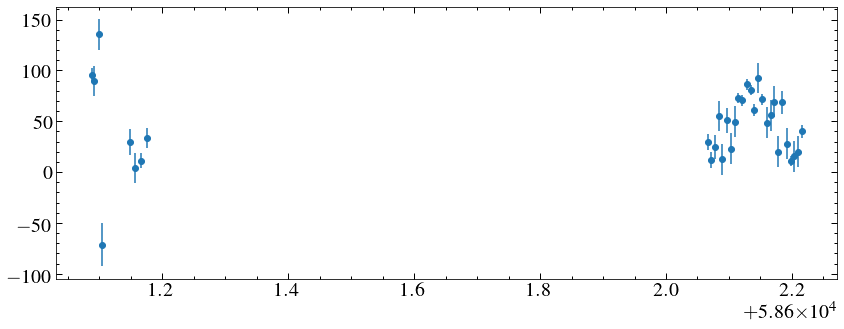

In [75]:
print(len(abs_dates), len(dvs_1), len(dvs_1e))
plt.errorbar(abs_dates, dvs_1, yerr=dvs_1e, ls='none', marker='o')

Failed fits have beeb given a guess error of 15 km/s. LS?

4.217385925598945
4.297382063955235


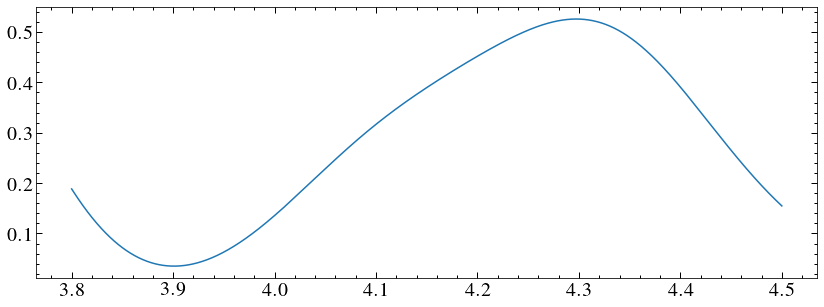

In [76]:

frequency = np.linspace(1/4.5, 1/3.8, 100000)
#frequency = np.linspace(1/5, 1/3, 100000)
t_abs = ((np.array(abs_dates) - min(np.array(abs_dates)) + (150/86400))) * 24
abs_power = LombScargle(t_abs, dvs_1, normalization='model').power(frequency)
abs_period = 1/frequency[np.argmax(abs_power)]
print(period)
print(abs_period)
plt.plot(1/frequency, abs_power)

Fold on original periio

(-10, 120)

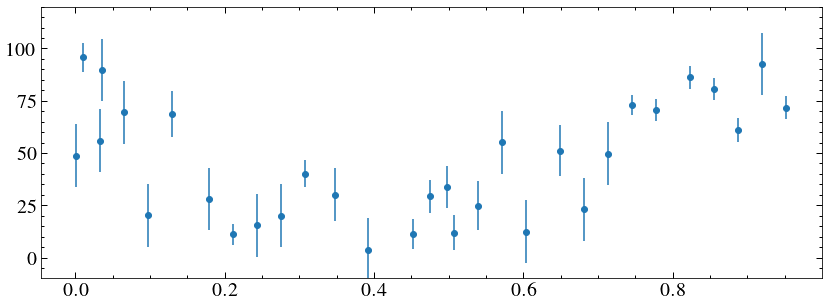

In [77]:
fold_abs = t_abs/abs_period %1
plt.errorbar(fold_abs, dvs_1, yerr=dvs_1e, ls='none', marker='o')
plt.ylim(-10, 120)

Yeah I'll take it - Need the 2018 data though.

In [78]:
old_path = '/home/david/work/1144_lt/spectra/SDSSJ1144_old/'
old_spec = glob.glob(old_path+'*VIS*.csv')
old_spec

['/home/david/work/1144_lt/spectra/SDSSJ1144_old/SDSS1144_2_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv',
 '/home/david/work/1144_lt/spectra/SDSSJ1144_old/SDSS1144_1_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv']

/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


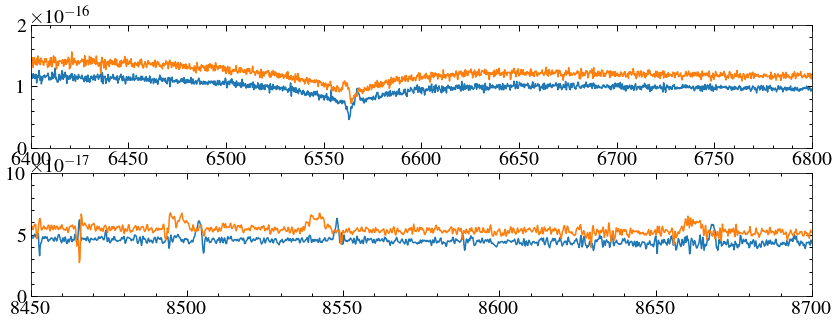

In [79]:
for s in old_spec:
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    plt.subplot(211)
    plt.plot(w,f)
    plt.xlim(6400, 6800)
    plt.ylim(0, 0.2e-15)
    plt.subplot(212)
    plt.plot(w,f)
    plt.xlim(8450, 8700)
    plt.ylim(0, 0.1e-15)
plt.show()

So 2 is clean and can be fit normallly. 1 needs 2 fits and we can use the rest to guess where it fits in.

/home/david/work/1144_lt/spectra/SDSSJ1144_old/SDSS1144_2_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv


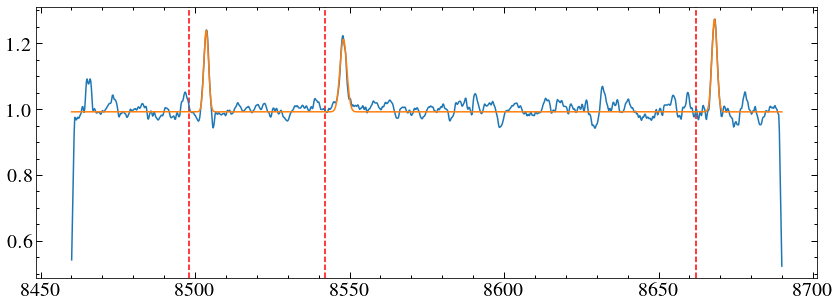

/home/david/work/1144_lt/spectra/SDSSJ1144_old/SDSS1144_1_SCI_SLIT_FLUX_MERGE1D_VIS_TAC.csv


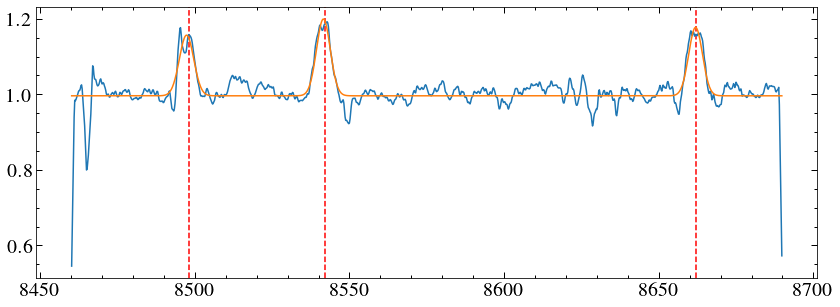

[204.8822752255248, -17.86201822384454] [2.6964617937588966, 3.7303943258170085]


In [80]:
fitter = fitting.LevMarLSQFitter()
old_dvs = []
old_dves = []
old_dates = []
old_xs = [8503.73,8498.5]
for s, x in zip(old_spec, old_xs):
    print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
  #  plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    old_dates.append(date)
    
    #print(slines)
    plt.figure() 
    for i in range(len(lines)):
        line = lines[i]
        guess = slines[i]
        if i == 0:
            gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
        else:
            gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
        plt.axvline(line, c='r', ls='--')
    gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=10000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    
    #print(gg_fit)
    #print(fit_e)
    
    plt.plot(w, f)
    plt.plot(w, gg_fit(w))
    plt.show()
    obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
    obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]
    
    e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
    e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
    es = np.mean([e_up, e_down], axis=0)
   # print(len(es))
    dv, dve = dv_average(dv, es)
    old_dvs.append(dv)
    old_dves.append(dve)
print(old_dvs, old_dves)

Ok, first one worked, need a different approach to second.

Model: CompoundModel953
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6]
Components: 
    [0]: <Const1D(amplitude=1.)>

    [1]: <Gaussian1D(amplitude=1., mean=8494.8, stddev=1.)>

    [2]: <Gaussian1D(amplitude=1., mean=8538.85330136, stddev=1.)>

    [3]: <Gaussian1D(amplitude=1., mean=8658.857813, stddev=1.)>

    [4]: <Gaussian1D(amplitude=1., mean=8498.2, stddev=1.)>

    [5]: <Gaussian1D(amplitude=1., mean=8542.27093346, stddev=1.)>

    [6]: <Gaussian1D(amplitude=1., mean=8662.32347629, stddev=1.)>
Parameters:
       amplitude_0        amplitude_1     ...       mean_6          stddev_6    
    ----------------- ------------------- ... ----------------- ----------------
    0.993925840254146 0.15576301736529255 ... 8663.292975158978 1.38893334660298


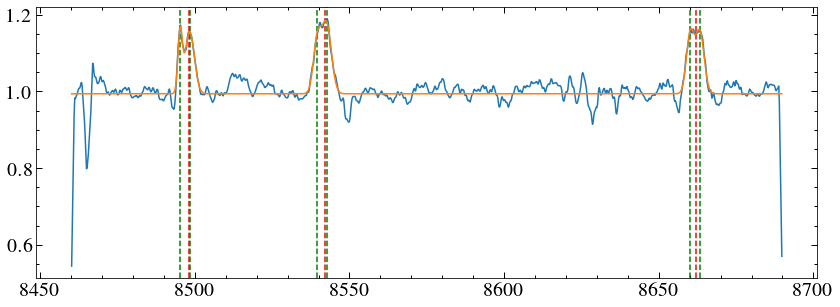

[-97.49333095478698, -86.09507923237399, -68.18102747074032] [16.1123309  97.24950047 83.82269186]
[11.849586364299334, 19.863882135187843, 39.90391022581203] [16.44268693 89.78918487 83.43620053]
[-96.18186760319136, 13.116201756990355] [3.9658673820043617, 3.8017935474268123]


In [81]:
b_dvs = []
b_dvs_e = []
w, f, e = np.loadtxt(old_spec[1], unpack=True, delimiter=',')
xs = [8494.8, 8498.2]

slines = get_shifted_lines(xs[0], lines)
mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
mask2 = (w> 8460) & (w < 8690) 
w, f, e =  make_plot_spec(w, f,e , mask1, mask2)
#  plt.plot(w, f)
date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
old_dates.append(date)

#print(slines)
plt.figure() 
for i in range(len(lines)):
    line = lines[i]
    guess = slines[i]
    if i == 0:
        gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
    else:
        gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
    plt.axvline(line, c='r', ls='--')
    
#add a second set of gaussians
slines = get_shifted_lines(xs[1], lines)
for i in range(len(lines)):
    line = lines[i]
    guess = slines[i]
    gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)

    
    
gg_fit = fitter(gg_init, w, f, weights=1/e, maxiter=10000)
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))

print(gg_fit)
#print(fit_e)

for i in range(6):
    line = gg_fit[i+1].mean.value
    plt.axvline(line, c='g', ls='--') 

plt.plot(w, f)
plt.plot(w, gg_fit(w))
plt.show()
obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]

e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
es = np.mean([e_up, e_down], axis=0)
# print(len(es))
print(dv, es)
dv, dve = dv_average(dv, es)
b_dvs.append(dv)
b_dvs_e.append(dve)

obs_lines = [gg_fit[4].mean*u.AA, gg_fit[5].mean*u.AA, gg_fit[6].mean*u.AA]
obs_e = [fit_e[11]*u.AA, fit_e[14]*u.AA, fit_e[17]*u.AA]
dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]

e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
es = np.mean([e_up, e_down], axis=0)
# print(len(es))
print(dv, es)
dv, dve = dv_average(dv, es)
b_dvs.append(dv)
b_dvs_e.append(dve)

print(b_dvs, b_dvs_e)

Tada!

Add the first one then find the dates for the second.

In [86]:
fits.getheader(old_spec[0][:-3]+'fits')['EXPTIME']

1440.0

In [85]:
date1, dv1, dve1 = old_dates[0], old_dvs[0], old_dves[0]

In [88]:
date1 += 1440/86400
time1 = date1*24

<ErrorbarContainer object of 3 artists>

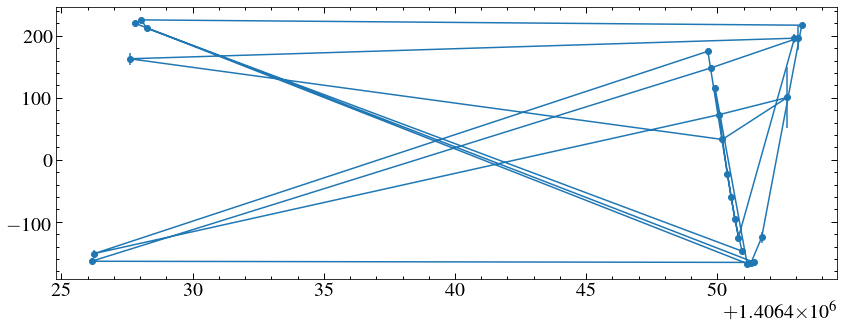

In [166]:
t_unnorm =(np.array(dates) + (150/86400)) *24
plt.errorbar(t_unnorm, dvs, yerr=dves, marker='o')


In [167]:
all_t = np.append(time1,t_unnorm)
all_dvs = np.append(dv1, dvs )
all_dves = np.append(dve1, dves)
aargs = np.argsort(all_t)
all_t, all_dvs, all_dves = all_t[aargs], all_dvs[aargs], all_dves[aargs]

(0, 50)

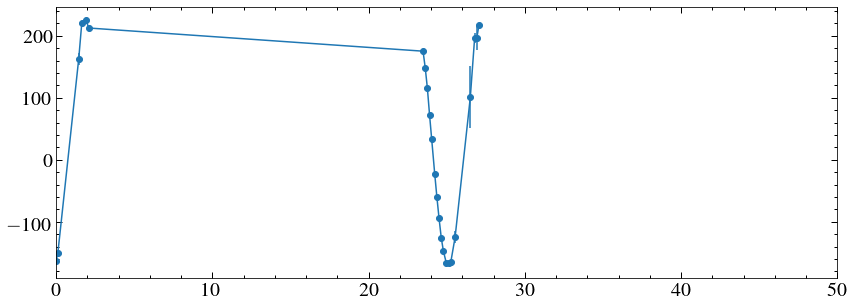

In [168]:
plt.errorbar(all_t-all_t[1], all_dvs, yerr=all_dves, marker='o')
plt.xlim(0, 50)

4.217916984632368


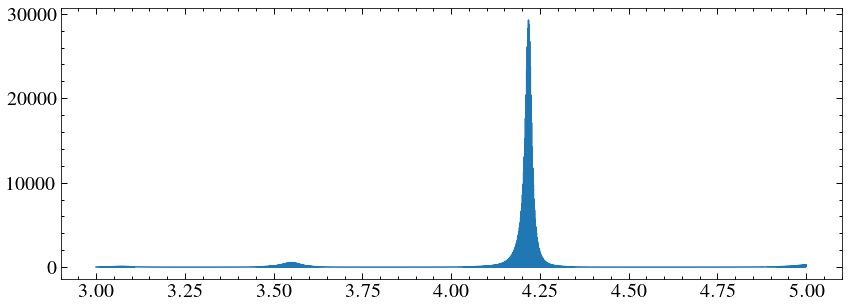

In [179]:
#frequency = np.linspace(1/5, 1/3, 100000)
#power = LombScargle(all_t, all_dvs, all_dves, normalization='model').power(frequency)
frequency, power = LombScargle(all_t, all_dvs, all_dves, normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)
period = 1/frequency[np.argmax(power)]
print(period)
plt.plot(1/frequency, power)
#plt.xlim(2, 10)

<ErrorbarContainer object of 3 artists>

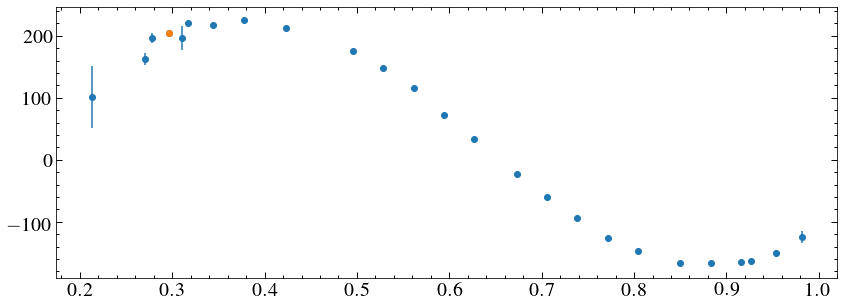

In [183]:
plt.errorbar((all_t/period %1), all_dvs, yerr=all_dves, marker='o', ls='none')
plt.errorbar((time1/period %1), dv1, yerr=dve1, marker='o', ls='none')

Ok, now how about the other spectrum?

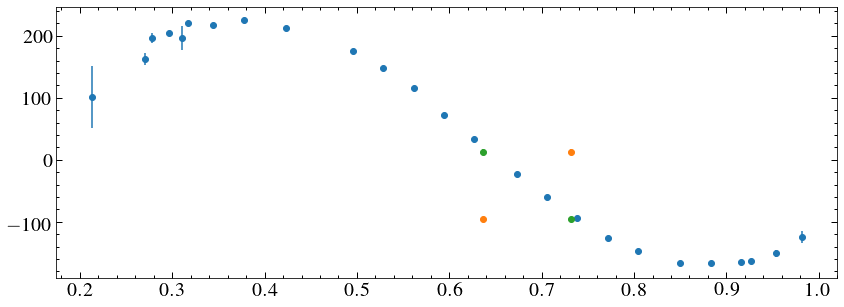

4.204294582211447


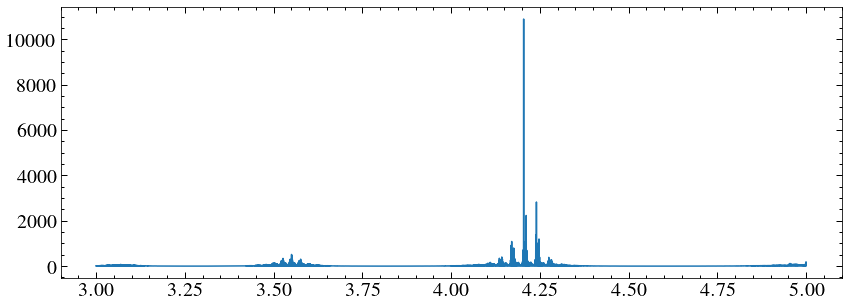

4.217916984632368


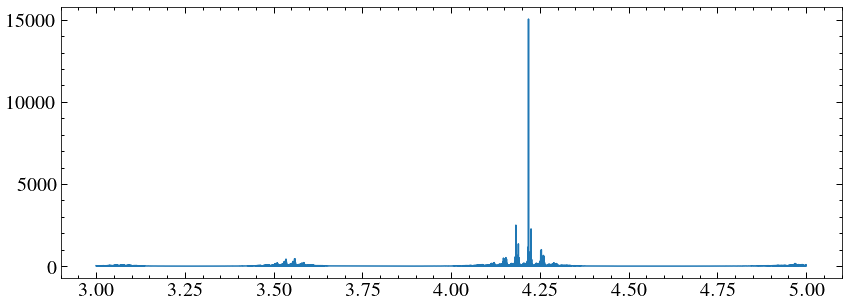

In [193]:
texp = 1440/86400
test_1 = np.array([old_dates[1]+texp/2, old_dates[1]+texp*1.5 ])*24
test_2 = test_1[::-1]
plt.errorbar((all_t/period %1), all_dvs, yerr=all_dves, marker='o', ls='none')
for test in [test_1, test_2]:
    plt.errorbar((test/period %1), b_dvs, yerr=b_dvs_e, marker='o', ls='none')
plt.show()
for test in [test_1, test_2]:
    frequency, power = LombScargle(np.append(all_t, test), np.append(all_dvs, b_dvs), np.append(all_dves, b_dvs_e), normalization='model').autopower(minimum_frequency = 1/5, maximum_frequency = 1/3)
    period = 1/frequency[np.argmax(power)]
    print(period)
    plt.plot(1/frequency, power)
    plt.show()
        

In [ ]:
b_times = [,58189.097671] #checking eso archive